In [11]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

try:
    import dice_ml
except Exception:
    dice_ml = None

try:
    from IPython.display import display 
except Exception:  
    display = None

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

TARGET_COL = "status_eq_2"
TARGET_DESC = "status == 2 vs others"

THR = 0.50
CALIB_FRAC = 0.20
N_BOOT = 50  # Computational constraint 

def header(title: str) -> None:
    print(f"\n{title}\n" + "-" * len(title))


def show(df: pd.DataFrame, title: str, n: int | None = None) -> None:
    print(f"\n{title}")
    if n is not None:
        df = df.head(n)
    if display is not None:
        display(df)
    else:
        print(df)


def show_table(df: pd.DataFrame, title: str | None = None, max_width_px: int = 900):
    """ Default notebook output (no HTML/CSS).`max_width_px` kept only to avoid changing call sites."""
    if title:
        header(title)
    if display is not None:
        display(df)
    else:
        print(df)

def show_note(text: str, note_type: str = "info", max_width_px: int = 900):
    """ Default text output (no HTML/CSS). """
    tag = {
        "info": "INFO",
        "success": "SUCCESS",
        "warning": "WARNING",
        "error": "ERROR",
    }.get(note_type, "INFO")
    print(f"\n[{tag}] {text}\n")

In [12]:
#Data splitting and preprocessing 
df = pd.read_csv("pbc_clinical_cohort.csv")
if "alk.phos" in df.columns:
    df = df.rename(columns={"alk.phos": "alk_phos"})

df[TARGET_COL] = (df["status"] == 2).astype(int)

ALL_FEATURES = [
    "age",
    "sex",
    "ascites",
    "hepato",
    "spiders",
    "edema",
    "bili",
    "chol",
    "albumin",
    "copper",
    "alk_phos",
    "ast",
    "trig",
    "platelet",
    "protime",
    "stage",
]
ALL_FEATURES = [c for c in ALL_FEATURES if c in df.columns]

X_raw = df[ALL_FEATURES].copy()
y = df[TARGET_COL].copy()

# 60/20/20 split
X_train_raw, X_tmp_raw, y_train, y_tmp = train_test_split(
    X_raw, y, test_size=0.40, random_state=RANDOM_STATE, stratify=y
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_tmp_raw, y_tmp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_tmp
)

sex_map = {"m": 0, "f": 1}


def fit_preprocess_stats(X_fit: pd.DataFrame) -> dict:
    """Fit preprocessing stats on a fit split only (mode for sex + numeric medians)."""
    X_fit = X_fit.copy()

    if "sex" in X_fit.columns:
        s = X_fit["sex"].astype(str).str.lower().map(sex_map)
        sex_mode = int(s.mode()[0]) if not s.mode().empty else 0
    else:
        sex_mode = 0

    X_tmp = X_fit.copy()
    if "sex" in X_tmp.columns:
        X_tmp["sex"] = (
            X_tmp["sex"].astype(str).str.lower().map(sex_map).fillna(sex_mode).astype(int)
        )

    num_cols = X_tmp.select_dtypes(include=[np.number]).columns.tolist()
    medians = X_tmp[num_cols].median()
    return {"sex_mode": sex_mode, "num_cols": num_cols, "medians": medians}


def apply_preprocess(X: pd.DataFrame, stats: dict) -> pd.DataFrame:
    """Apply preprocessing using already-fitted stats."""
    X2 = X.copy()

    if "sex" in X2.columns:
        X2["sex"] = X2["sex"].astype(str).str.lower().map(sex_map)
        X2["sex"] = X2["sex"].fillna(stats["sex_mode"]).astype(int)

    for c in stats["num_cols"]:
        if c in X2.columns:
            X2[c] = X2[c].fillna(stats["medians"][c])

    if "age" in X2.columns:
        X2["age"] = X2["age"].round(2)

    return X2


# Global preprocessing for non-CV parts 
stats_global = fit_preprocess_stats(X_train_raw)
X_train = apply_preprocess(X_train_raw, stats_global)
X_val = apply_preprocess(X_val_raw, stats_global)
X_test = apply_preprocess(X_test_raw, stats_global)

DICE_CONTINUOUS = [
    c
    for c in [
        "age",
        "albumin",
        "alk_phos",
        "ast",
        "bili",
        "chol",
        "copper",
        "platelet",
        "protime",
        "trig",
    ]
    if c in X_train.columns
]
IMMUTABLE = [
    c
    for c in ["age", "sex", "stage", "ascites", "hepato", "spiders", "edema"]
    if c in X_train.columns
]

summary = pd.DataFrame(
    [
        ["Cohort size", len(df)],
        ["Task", TARGET_DESC],
        ["Positive class", f"{int(y.sum())} ({y.mean()*100:.1f}%)"],
        ["Train / Val / Test", f"{len(X_train)} / {len(X_val)} / {len(X_test)}"],
        ["# Features", len(ALL_FEATURES)],
    ],
    columns=["Metric", "Value"],
)
show_table(summary, "Dataset summary")



Dataset summary
---------------


,Metric,Value
0,Cohort size,419
1,Task,status == 2 vs others
2,Positive class,161 (38.4%)
3,Train / Val / Test,251 / 84 / 84
4,# Features,16


In [13]:
#Models and metric helpers
def make_gb() -> GradientBoostingClassifier:
    return GradientBoostingClassifier(
        n_estimators=50,
        max_depth=2,
        learning_rate=0.05,
        min_samples_split=10,
        min_samples_leaf=15,
        subsample=0.8,
        random_state=RANDOM_STATE,
    )


def make_lr() -> LogisticRegression:
    return LogisticRegression(
        max_iter=2000,
        random_state=RANDOM_STATE,
        class_weight="balanced",
    )


def calc_metrics(y_true, y_prob, thr=0.5) -> dict:
    """Keep metrics minimal: ROC-AUC + Accuracy + Brier."""
    y_pred = (np.asarray(y_prob) >= thr).astype(int)
    return {
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Brier": brier_score_loss(y_true, y_prob),
    }


In [20]:
#5 fold CV
X_dev_raw = pd.concat([X_train_raw, X_val_raw], axis=0)
y_dev = pd.concat([y_train, y_val], axis=0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

gb_uncal_mets = []
gb_cal_mets = []
lr_mets = []

for fold_id, (tr_idx, va_idx) in enumerate(cv.split(X_dev_raw, y_dev), start=1):
    X_tr_full = X_dev_raw.iloc[tr_idx]
    y_tr_full = y_dev.iloc[tr_idx]
    X_va_raw = X_dev_raw.iloc[va_idx]
    y_va = y_dev.iloc[va_idx]

    # Split training fold into fit/calibration
    X_fit_raw, X_cal_raw, y_fit, y_cal = train_test_split(
        X_tr_full,
        y_tr_full,
        test_size=CALIB_FRAC,
        random_state=RANDOM_STATE + fold_id,
        stratify=y_tr_full,
    )

    # Preprocessing fitted on X_fit only to avoid leakage inside the CV
    stats_fold = fit_preprocess_stats(X_fit_raw)
    X_fit = apply_preprocess(X_fit_raw, stats_fold)
    X_cal = apply_preprocess(X_cal_raw, stats_fold)
    X_va = apply_preprocess(X_va_raw, stats_fold)

    # GB - Uncalibrated 
    gb = make_gb()
    gb.fit(X_fit, y_fit)
    prob_gb = gb.predict_proba(X_va)[:, 1]
    gb_uncal_mets.append(calc_metrics(y_va, prob_gb, thr=THR))

    # GB - calibrated
    gb_base = make_gb()
    gb_base.fit(X_fit, y_fit)
    gb_fold = CalibratedClassifierCV(gb_base, method="sigmoid", cv="prefit")
    gb_fold.fit(X_cal, y_cal)

    prob_gbc = gb_fold.predict_proba(X_va)[:, 1]
    gb_cal_mets.append(calc_metrics(y_va, prob_gbc, thr=THR))

    # LR
    lr = make_lr()
    lr.fit(X_fit, y_fit)
    prob_lr = lr.predict_proba(X_va)[:, 1]
    lr_mets.append(calc_metrics(y_va, prob_lr, thr=THR))


def mean_of(mets, key: str) -> float:
    return float(np.mean([m[key] for m in mets]))


cv_results = []
for name, mets in [
    ("GB (uncalibrated)", gb_uncal_mets),
    ("GB (calibrated)", gb_cal_mets),
    ("Logistic Regression", lr_mets),
]:
    cv_results.append(
        {
            "Model": name,
            "ROC-AUC": f"{mean_of(mets, 'ROC-AUC'):.3f}",
            "Accuracy": f"{mean_of(mets, 'Accuracy'):.3f}",
            "Brier": f"{mean_of(mets, 'Brier'):.3f}",
        }
    )

show_table(pd.DataFrame(cv_results), "5-Fold CV Results (Train+Val)")

show_note(
    "Observation: Calibration can sometimes improve probability quality (Brier), but not always accuracy. "
    "Accuracy depends on a threshold and calibration mainly targets probability estimates.",
    note_type="info",
)



5-Fold CV Results (Train+Val)
-----------------------------


,Model,ROC-AUC,Accuracy,Brier
0,GB (uncalibrated),0.840,0.776,0.155
1,GB (calibrated),0.840,0.776,0.159
2,Logistic Regression,0.823,0.752,0.168



[INFO] Observation: Calibration can sometimes improve probability quality (Brier), but not always accuracy. Accuracy depends on a threshold and calibration mainly targets probability estimates.




Final Test Results (Test touched once)
--------------------------------------


,Model,ROC-AUC,Accuracy,Brier
0,GB (uncalibrated),0.812,0.738,0.176
1,GB (calibrated),0.812,0.726,0.186
2,Logistic Regression,0.772,0.714,0.183


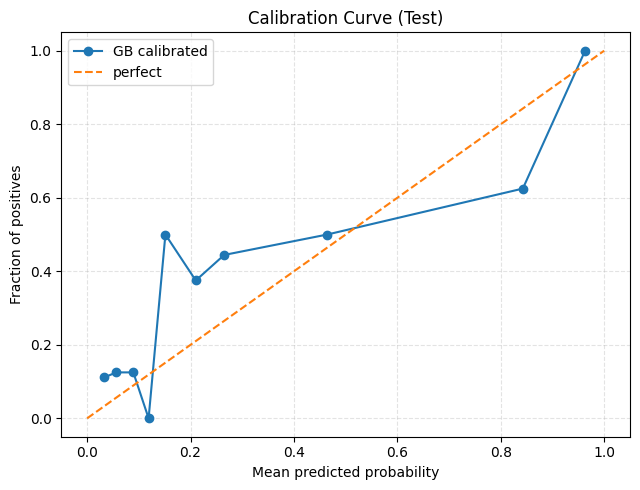

In [21]:
# Final training
X_dev = pd.concat([X_train, X_val], axis=0)
y_dev2 = pd.concat([y_train, y_val], axis=0)

X_fit_dev, X_cal_dev, y_fit_dev, y_cal_dev = train_test_split(
    X_dev, y_dev2, test_size=CALIB_FRAC, random_state=RANDOM_STATE, stratify=y_dev2
)

gb_final = make_gb()
gb_final.fit(X_fit_dev, y_fit_dev)

gb_cal_final = CalibratedClassifierCV(gb_final, method="sigmoid", cv="prefit")
gb_cal_final.fit(X_cal_dev, y_cal_dev)

lr_final = make_lr()
lr_final.fit(X_fit_dev, y_fit_dev)

# Test touch 
prob_gb_test = gb_final.predict_proba(X_test)[:, 1]
prob_gbc_test = gb_cal_final.predict_proba(X_test)[:, 1]
prob_lr_test = lr_final.predict_proba(X_test)[:, 1]

test_rows = [
    {
        "Model": "GB (uncalibrated)",
        **{k: v for k, v in calc_metrics(y_test, prob_gb_test, THR).items()},
    },
    {
        "Model": "GB (calibrated)",
        **{k: v for k, v in calc_metrics(y_test, prob_gbc_test, THR).items()},
    },
    {
        "Model": "Logistic Regression",
        **{k: v for k, v in calc_metrics(y_test, prob_lr_test, THR).items()},
    },
]
test_df = pd.DataFrame(test_rows)
for c in ["ROC-AUC", "Accuracy", "Brier"]:
    test_df[c] = test_df[c].map(lambda x: f"{float(x):.3f}")

show_table(test_df, "Final Test Results (Test touched once)")

plt.figure(figsize=(6.5, 5))
frac_pos, mean_pred = calibration_curve(y_test, prob_gbc_test, n_bins=10, strategy="quantile")
plt.plot(mean_pred, frac_pos, marker="o", label="GB calibrated")
plt.plot([0, 1], [0, 1], linestyle="--", label="perfect")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Test)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()



In [22]:
# Counterfactual 
if dice_ml is None:
    show_note("DiCE is not installed. Run: pip install dice-ml", note_type="error")
    raise SystemExit

# Picking high risk validation example 
val_proba = gb_cal_final.predict_proba(X_val)[:, 1]
sorted_idx = np.argsort(-val_proba)

pick_rank = min(15, len(sorted_idx) - 1)
target_idx = int(X_val.index[sorted_idx[pick_rank]])
target_risk = float(val_proba[sorted_idx[pick_rank]])

target_instance = X_val.loc[[target_idx]]
baseline = target_instance.iloc[0]

show_table(
    pd.DataFrame([[target_idx, f"{target_risk*100:.1f}%"]], columns=["Val index", "Pred risk"]),
    "Picked validation case",
)

mutable = [c for c in X_train.columns if c not in IMMUTABLE]
features_to_vary = [
    c
    for c in ["bili", "alk_phos", "ast", "copper", "protime", "albumin", "chol", "platelet"]
    if c in mutable
][:8]

clinical_caps = {
    "bili": (0.3, 25.0),
    "albumin": (2.0, 4.5),
    "alk_phos": (40.0, 3500.0),
    "ast": (10.0, 400.0),
    "copper": (10.0, 250.0),
    "protime": (9.0, 16.0),
    "chol": (100.0, 800.0),
    "platelet": (20.0, 600.0),
    "trig": (20.0, 1200.0),
}

P_LO, P_HI = 1.0, 99.0
train_caps = {}
for f in features_to_vary:
    if f in X_train.columns and X_train[f].dtype.kind in "biufc":
        train_caps[f] = (
            float(np.nanpercentile(X_train[f].values, P_LO)),
            float(np.nanpercentile(X_train[f].values, P_HI)),
        )


def cap_intersection(f):
    lo, hi = -np.inf, np.inf
    if f in clinical_caps:
        lo, hi = clinical_caps[f]
    if f in train_caps:
        lo = max(lo, train_caps[f][0])
        hi = min(hi, train_caps[f][1])
    return float(lo), float(hi)


DIRECTIONAL = True
bad_labs = {"bili", "alk_phos", "ast", "copper", "protime", "chol", "trig"}

bounds = {}
for f in features_to_vary:
    base = float(baseline[f])
    lo, hi = cap_intersection(f)

    if DIRECTIONAL:
        if f == "albumin":
            lo = max(lo, base)  # assuming that the higher albumin is better
        elif f in bad_labs:
            hi = min(hi, base)  # assuming that the lower adverse labs is better

    if lo > hi:
        lo, hi = hi, lo
    bounds[f] = [lo, hi]

bounds_df = pd.DataFrame(
    [[f, float(baseline[f]), bounds[f]] for f in features_to_vary],
    columns=["Feature", "Baseline", "Permitted range"],
)
show_table(bounds_df, "Permitted ranges (train percentiles ∩ clinical caps)")

dice_df = pd.concat([X_train, y_train.rename(TARGET_COL)], axis=1)
dice_data = dice_ml.Data(
    dataframe=dice_df,
    continuous_features=DICE_CONTINUOUS,
    outcome_name=TARGET_COL,
)
dice_model = dice_ml.Model(model=gb_cal_final, backend="sklearn")

dice = dice_ml.Dice(dice_data, dice_model, method="genetic")
cf_result = dice.generate_counterfactuals(
    target_instance,
    total_CFs=5,
    desired_class=0,
    features_to_vary=features_to_vary,
    permitted_range=bounds,
    verbose=False,
)

cf_df = cf_result.cf_examples_list[0].final_cfs_df
method_used = "genetic"

if len(cf_df) < 3:
    dice2 = dice_ml.Dice(dice_data, dice_model, method="random")
    cf_result2 = dice2.generate_counterfactuals(
        target_instance,
        total_CFs=5,
        desired_class=0,
        features_to_vary=features_to_vary,
        permitted_range=bounds,
        verbose=False,
    )
    cf_df = cf_result2.cf_examples_list[0].final_cfs_df
    method_used = "random"

clear_output(wait=True)

cf_features = cf_df.drop(columns=[TARGET_COL], errors="ignore")
cf_risk = (gb_cal_final.predict_proba(cf_features)[:, 1] * 100).round(1)

show_cols = [c for c in features_to_vary if c in cf_features.columns]
cf_compact = cf_features[show_cols].copy()
cf_compact.insert(0, "Pred risk", cf_risk.astype(str) + "%")

show_table(pd.DataFrame([[method_used, len(cf_df)]], columns=["Method", "#CFs"]), "Counterfactual generation")
show_table(cf_compact, "Counterfactuals (compact)")

show_note(
    "Note: These counterfactuals show feature combinations that change the model prediction, "
    "but they are not causal. Changing a lab value does not guarantee the real clinical outcome changes.",
    note_type="warning",
)




Counterfactual generation
-------------------------


,Method,#CFs
0,genetic,5



Counterfactuals (compact)
-------------------------


,Pred risk,bili,alk_phos,ast,copper,protime,albumin,chol,platelet
0,47.5%,1.4,1282.0,111.0,71.0,10.5,3.24,310.0,231.0
0,43.8%,0.7,1282.0,111.0,71.0,10.6,3.04,310.0,350.0
0,47.8%,1.4,1282.0,111.0,71.0,10.1,3.34,310.0,155.0
0,42.0%,0.7,1282.0,111.0,71.0,10.6,3.11,310.0,209.0
0,45.1%,1.4,1282.0,111.0,71.0,10.3,3.42,310.0,246.0



[WARNING] Note: These counterfactuals show feature combinations that change the model prediction, but they are not causal. Changing a lab value does not guarantee the real clinical outcome changes.




Baseline vs Best Counterfactual
-------------------------------


,Case,Pred risk
0,Baseline,89.1%
1,Best CF,42.0%



Changed features
----------------


,Feature,Baseline,CF,Delta
2,platelet,331.00,209.00,-122.00
3,protime,12.10,10.60,-1.50
0,bili,1.40,0.70,-0.70
1,albumin,3.04,3.11,0.07



Plausibility (kNN distance)
---------------------------


,kNN dist baseline→train,kNN dist CF→train
0,2.878,2.026



Bootstrap uncertainty (n=50)
----------------------------


,Point,Bootstrap 95% interval
0,42.0%,17.6% → 37.6%


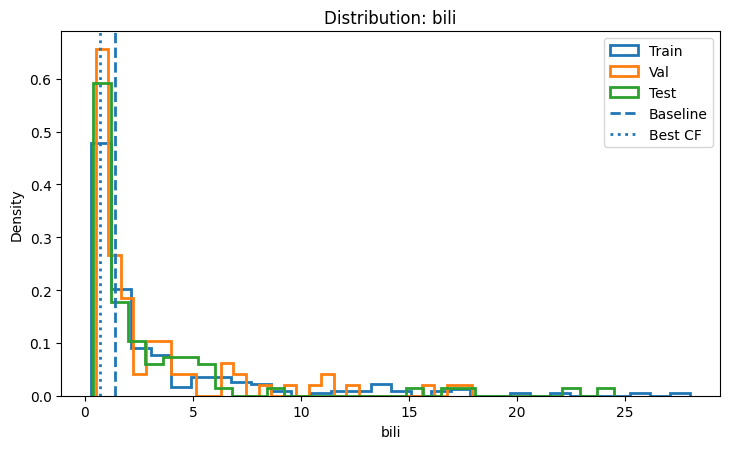

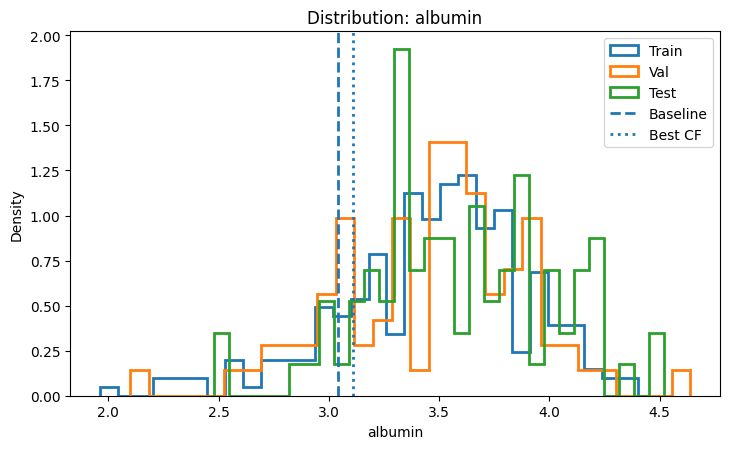

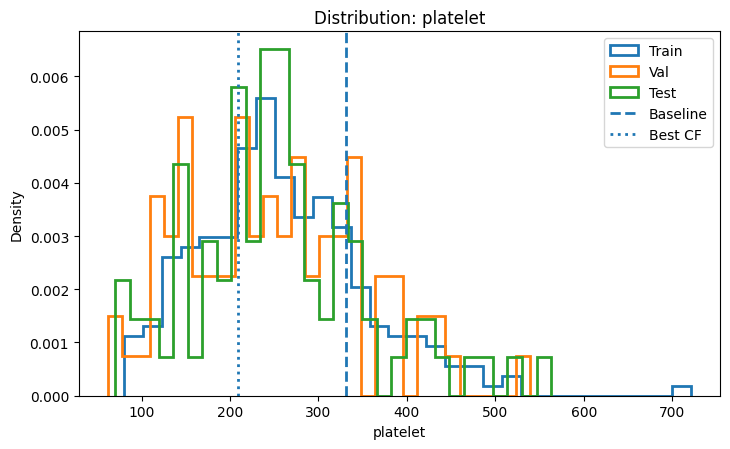

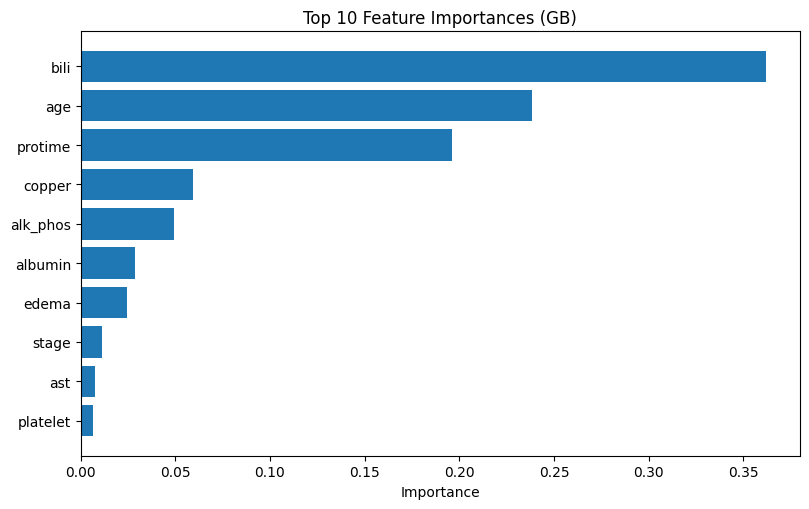

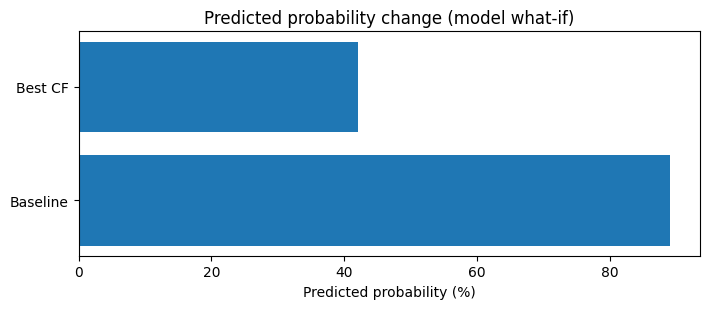

In [23]:
#CF analysis
FEATURE_COLS = list(X_train.columns)


def to_model_X(df_like: pd.DataFrame) -> pd.DataFrame:
    return df_like.reindex(columns=FEATURE_COLS)


cf_full = to_model_X(cf_df.drop(columns=[TARGET_COL], errors="ignore"))
cf_probs = gb_cal_final.predict_proba(cf_full)[:, 1]
best_cf = cf_full.iloc[[int(np.argmin(cf_probs))]].copy()

# immutables
for f in IMMUTABLE:
    if f in best_cf.columns and f in target_instance.columns:
        best_cf.iloc[0, best_cf.columns.get_loc(f)] = target_instance.iloc[0][f]

best_risk = float(gb_cal_final.predict_proba(best_cf)[:, 1][0])
baseline_risk = float(target_risk)

show_table(
    pd.DataFrame(
        [
            ["Baseline", f"{baseline_risk*100:.1f}%"],
            ["Best CF", f"{best_risk*100:.1f}%"],
        ],
        columns=["Case", "Pred risk"],
    ),
    "Baseline vs Best Counterfactual",
)

# what changed
rows = []
for f in FEATURE_COLS:
    b = float(target_instance.iloc[0][f])
    c = float(best_cf.iloc[0][f])
    if abs(b - c) > 1e-6:
        rows.append([f, b, c, c - b])

diff_df = pd.DataFrame(rows, columns=["Feature", "Baseline", "CF", "Delta"])
if len(diff_df):
    show_table(diff_df.sort_values("Delta", key=lambda s: s.abs(), ascending=False), "Changed features")
else:
    show_note("Best CF equals baseline (rare).", note_type="warning")

# kNN plausibility
mu = X_train.mean(axis=0)
sd = X_train.std(axis=0).replace(0, 1.0)
Xs = (X_train - mu) / sd
base_s = (to_model_X(target_instance) - mu) / sd
cf_s = (best_cf - mu) / sd

nn = NearestNeighbors(n_neighbors=min(5, len(X_train)))
nn.fit(Xs.values)
d_base = float(nn.kneighbors(base_s.values, return_distance=True)[0].mean())
d_cf = float(nn.kneighbors(cf_s.values, return_distance=True)[0].mean())

show_table(
    pd.DataFrame([[f"{d_base:.3f}", f"{d_cf:.3f}"]], columns=["kNN dist baseline→train", "kNN dist CF→train"]),
    "Plausibility (kNN distance)",
)

# bootstrap instability 
boot_preds = []
for _ in range(N_BOOT):
    boot_idx = np.random.choice(len(X_train), len(X_train), replace=True)
    Xb = X_train.iloc[boot_idx]
    yb = y_train.iloc[boot_idx]

    m = GradientBoostingClassifier(
        n_estimators=50,
        max_depth=2,
        learning_rate=0.05,
        min_samples_split=10,
        min_samples_leaf=15,
        subsample=0.8,
        random_state=None,
    )
    m.fit(Xb, yb)

    mcal = CalibratedClassifierCV(m, method="sigmoid", cv="prefit")
    mcal.fit(X_val, y_val)

    boot_preds.append(float(mcal.predict_proba(best_cf)[:, 1][0]))

lo, hi = np.percentile(boot_preds, [2.5, 97.5])
show_table(
    pd.DataFrame(
        [[f"{best_risk*100:.1f}%", f"{lo*100:.1f}% → {hi*100:.1f}%"]],
        columns=["Point", "Bootstrap 95% interval"],
    ),
    f"Bootstrap uncertainty (n={N_BOOT})",
)

# distributions
plot_feats = diff_df["Feature"].tolist()[:3] if len(diff_df) else []
for feat in plot_feats:
    plt.figure(figsize=(7.4, 4.6))
    plt.hist(X_train[feat], bins=30, density=True, histtype="step", linewidth=2, label="Train")
    plt.hist(X_val[feat], bins=30, density=True, histtype="step", linewidth=2, label="Val")
    plt.hist(X_test[feat], bins=30, density=True, histtype="step", linewidth=2, label="Test")
    plt.axvline(float(target_instance.iloc[0][feat]), linestyle="--", linewidth=2, label="Baseline")
    plt.axvline(float(best_cf.iloc[0][feat]), linestyle=":", linewidth=2, label="Best CF")
    plt.title(f"Distribution: {feat}")
    plt.xlabel(feat)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# feature importance
fi = pd.DataFrame({"feature": FEATURE_COLS, "importance": gb_final.feature_importances_})
fi = fi.sort_values("importance", ascending=False).head(10)
plt.figure(figsize=(8.2, 5.2))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (GB)")
plt.tight_layout()
plt.show()

# probability change plot
plt.figure(figsize=(7.2, 3.2))
plt.barh(["Baseline", "Best CF"], [baseline_risk * 100, best_risk * 100])
plt.xlabel("Predicted probability (%)")
plt.title("Predicted probability change (model what-if)")
plt.tight_layout()
plt.show()



## TAKEAWAYS:
    - Gradient Boosting achieved the strongest ROC-AUC in this setup.
    - Calibration (sigmoid) changed probability quality (Brier) more than accuracy.
    - Counterfactuals show model what-if changes, not causal interventions.

## LIMITATIONS:
    - Single dataset and a simple feature set; no external validation.
    - Threshold fixed at 0.5. The accuracy depends on threshold choice.
    - DiCE counterfactuals depend on constraints and different constraints can change results.
